In [1]:
#установим folium для визуализации данных
!pip install folium -U

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import math as mth
import scipy.stats as stats
import plotly.express as px
from scipy import stats as st
import re
import warnings
warnings.filterwarnings(action='ignore')
from matplotlib import pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

In [3]:
pd.options.display.float_format = '{:.2f}'.format

try:
    df=pd.read_csv('/Users/vadimhlebnikov/Downloads/rest_data.csv')

except:
    df=pd.read_csv('/datasets/rest_data.csv')

# Описание проекта

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

## Содержание
* [Изучение и предобработка данных](#chapter1)
* [Анализ данных](#chapter2)
 * [Общая характеристика рынка](#chapter3)
 * [Доля и характеристики сетевых заведений](#chapter4)
 * [Вместимость заведений по форматам](#chapter5)
 * [Географический анализ рынка ](#chapter6)
* [Общие выводы](#chapter7)

## Изучение и предобработка данных <a class ="anchor" id="chapter1"></a>


In [4]:
df.info()

In [5]:
#меняем столбец с chain на булев тип
df = df.replace({'chain':{'да':True, 'нет':False}}) 

In [6]:
#Приводим названия и адреса к единому регистру
df['object_name'] = df['object_name'].str.lower()
df['address'] = df['address'].str.lower()

In [7]:
#определяем неявные дубликаты исключая столбец id
df[df.duplicated(subset=['object_name','chain','object_type','address','number'])]

In [8]:
#Удаляем выявленные дубликаты
df = df.drop_duplicates(subset=['object_name','chain','object_type','address','number'], keep='last')

In [9]:
# убираем наименование типов заведений для корректного агрегирования по сетям 
df['object_name'] = df['object_name'].str.replace("кафе ", "")
df['object_name'] = df['object_name'].str.replace("закусочная", "")
df['object_name'] = df['object_name'].str.replace("кофейня ", "")
df['object_name'] = df['object_name'].str.replace("пицерия", "")
df['object_name'] = df['object_name'].str.replace("пиццерия", "")
df['object_name'] = df['object_name'].str.replace("предприятие быстрого обслуживания", "")
df['object_name'] = df['object_name'].str.replace("пбо", "")
df['object_name'] = df['object_name'].str.replace("ресторан", "")
df['object_name'] = df['object_name'].str.replace("паб", "")
df['object_name'] = df['object_name'].str.replace("быстрого питания", "")
df['object_name'] = df['object_name'].str.replace("«", "")
df['object_name'] = df['object_name'].str.replace("»", "")
df['object_name'] = df['object_name'].str.replace("-", " ")
df['object_name'] = df['object_name'].str.strip()

In [10]:
#переименовываем отдельные виды сетевых заведений для агрегирования в соответствующую сеть
df = df.replace({'object_name' : {'сабвей':'subway','синнабон':'cinnabon','старбакс':'starbucks','старбакс starbucks':'starbucks','black star burgers':'black star burger','братьев караваевых':'кулинарная лавка братьев караваевых','братья караваевы':'кулинарная лавка братьев караваевых','бургер кинг burger king':'бургер кинг','иль патио планета суши':'иль патио','быстрого питания kfc':'kfc','goodman гудман':'гудман',}})


In [11]:
point_names = df.groupby('object_name').count()['id'].sort_values(ascending=False).reset_index()


**Датасет содержит в себе данные довольно низкого качества**. В частности заведения одной и той же сети поименованы на разных языках, а также атрибутируются дополнительными техническими пометками, что будет затруднять агрегацию сетевых заведений. Данные по сетям с одним заведением в дальнейшем рекомендуется исключить из анализа, так как они скорее всего представляют из себя заведения, которые из-за некорректного сбора данных не агрегировались в сети.  

## Анализ данных <a class ="anchor" id="chapter2"></a>

In [12]:
#определяем виды заведений общепита в Москве
df['object_type'].unique()

## Общая характеристика рынка <a class ="anchor" id="chapter3"></a>

In [13]:
#смотрим на распределение числа заведений и посадочных мест по типам заведений
sum_table = pd.pivot_table(data=df[['number']],index=df['object_type'],aggfunc=['count','sum']).reset_index()
sum_table.columns = ['тип заведения','общее число заведений','общее число посадочных мест']
sum_table = sum_table.sort_values('общее число заведений',ascending=False)
sum_table['доля по числу заведений'] = sum_table['общее число заведений'] / sum_table['общее число заведений'].sum()
sum_table['доля по "посадке"'] = sum_table['общее число посадочных мест'] / sum_table['общее число посадочных мест'].sum()
sum_table
cm = sns.light_palette("blue", as_cmap=True)
sum_table.style.background_gradient(cmap=cm)

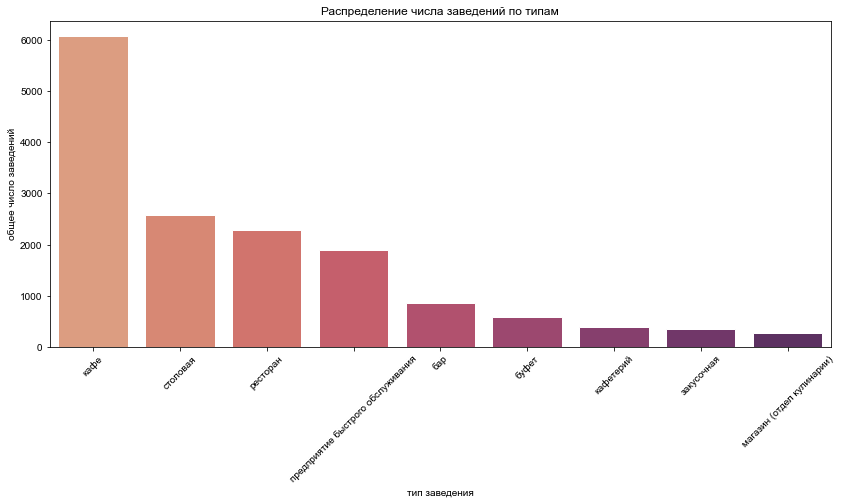

In [14]:
#строим барплот по числу заведений
plt.figure(
    figsize=(14, 6)) 
plt.xticks(rotation = 45)
plt.title ('Распределение числа заведений по типам')
sns.set_style('darkgrid')
ax = sns.barplot(x='тип заведения', y='общее число заведений', data=sum_table, palette="flare")


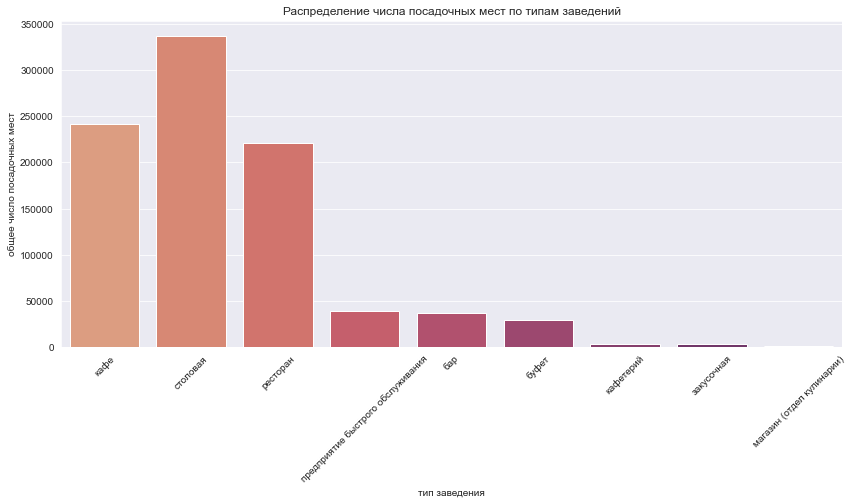

In [15]:
#смотрим как распределен рынок общепита в Москве по числу посадочных мест
plt.figure(
    figsize=(14, 6)) 
plt.xticks(rotation = 45)
plt.title ('Распределение числа посадочных мест по типам заведений')
ax = sns.barplot(x='тип заведения', y='общее число посадочных мест', data=sum_table, palette="flare")

**Подавляющее число заведений в Москве не являются сетевыми. На них приходится почти 81% рынка по числу заведений и почти 83% по "посадке"**. *Самый популярный формат заведения в среднем по рынку это кафе. На него приходится 40% московских заведений и 26% "посадки"*. Максимальная доля "посадки" у столовых (37%) при доле в числе заведений в 17%. На рестораны приходится 15% заведений и 24% мест. Предприятия быстрого обслуживания занимают 12% рынка по числу заведений и всего 4% по посадке.

С учетом отсутствия в датасете финансовой информации, можно отметить что **формат кафе является оптимальным в связи с высокой популярностью данного формата в Москве и сравнительно небольшим объемом инвестиций (медианная "посадка" в два раза ниже, чем в ресторане - 40 и 89 мест соответственно) и большей маржинальностью, чем в формате столовых.

## Доля и характеристики сетевых заведений <a class ="anchor" id="chapter4"></a>

In [16]:
# Рассчитываем долю сетевых заведенй
print(f"Количество сетевых заведений:{df['chain'].sum():.{0}f}")
print(f"Доля сетевых заведений:{df['chain'].sum() / df['chain'].count():.{3}f}")
print(f"Количество мест в сетевых заведениях:{df.query('chain == True')['number'].sum():.{0}f}")
print(f"Количество мест в несетевых заведениях:{df.query('chain == False')['number'].sum():.{0}f}")
print(f"Доля сетевых заведений по количеству посадочных мест:{df.query('chain == True')['number'].sum() / (df.query('chain == False')['number'].sum() + df.query('chain == True')['number'].sum()):.{3}f}")

In [17]:
#соотношения долей сетевых и несетевых заведений и числу заведений и по общей "посадке"
chain_ratio_points = [df['chain'].count() - df['chain'].sum(), df['chain'].sum()]
chain_ratio_numbers = [df.query('chain == False')['number'].sum(), df.query('chain == True')['number'].sum()]

In [18]:
#Среднее соличество мест в заведениях несетевого и сетевого типа 
display(df.groupby('chain')['number'].mean().reset_index())

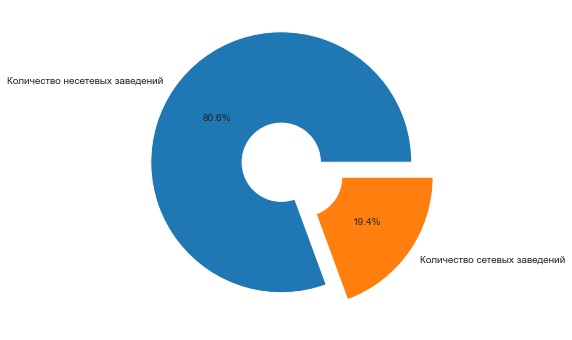

In [19]:
#Строим пайчарт по количеству сетевых и несетевых заведений
plt.figure(figsize=(14, 6)) 
labels2 = ['Количество несетевых заведений', 'Количество сетевых заведений']
colors = sns.color_palette()
explode = (0.1, 0.1)
plt.pie(chain_ratio_points, labels = labels2, colors = colors,autopct='%.1f%%',wedgeprops=dict(width=0.7),explode=explode)
plt.show()

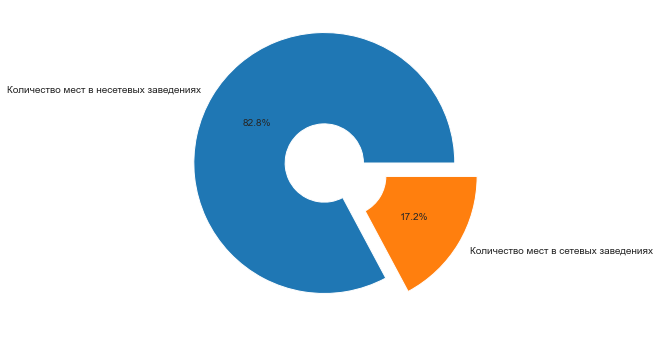

In [20]:
#Строим пайчарт по количеству посадочных мест
plt.figure(figsize=(14, 6)) 
labels1 = ['Количество мест в несетевых заведениях', 'Количество мест в сетевых заведениях']
colors = sns.color_palette()
plt.pie(chain_ratio_numbers, labels = labels1, colors = colors,autopct='%.1f%%',wedgeprops=dict(width=0.7),explode=explode)
plt.show()

In [21]:
type_pivot = pd.pivot_table(df, values='number', 
                                index='object_type', 
                                columns='chain', 
                                aggfunc= ['count','median']).reset_index()
type_pivot.columns = ['тип объекта','количество несетевых','количество сетевых','медианное количество мест в несетевых','медианное количество мест в сетевых']
type_pivot['доля сетевых'] = type_pivot['количество сетевых']/(type_pivot['количество сетевых'] + type_pivot['количество несетевых'])
type_pivot = type_pivot.sort_values('доля сетевых',ascending=False).reset_index(drop=True)

type_pivot = type_pivot.round(decimals=2)

cm = sns.light_palette("blue", as_cmap=True)
type_pivot.style.background_gradient(cmap=cm)

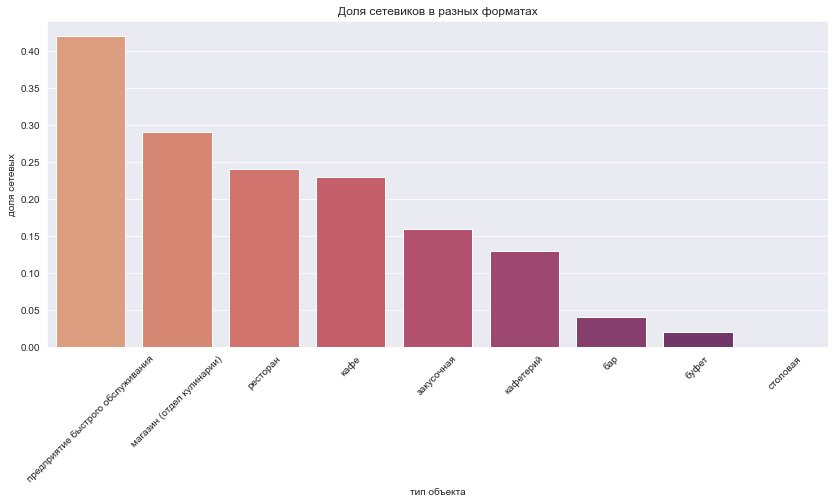

In [22]:
#Визуализируют долю сетевиков в разных форматах
plt.figure(
    figsize=(14, 6)) 
plt.xticks(rotation = 45)
plt.title ('Доля сетевиков в разных форматах')
ax = sns.barplot(x='тип объекта', y='доля сетевых', data=type_pivot, palette="flare")

**На рынке общественного питания Москвы самая большая доля сетевых объектов у предприятий быстрого обслуживания - 42%**. Также сравнительно велика доля сетевых магазинов с кулинарными отделами (29%). Почти четверть объектов являются сетевыми в форматах "ресторан" и "кафе" (24 и 23% соответственно).

In [24]:
#группируем информацию по сетям
lm_df_chain = (df.query('chain == True')
               .groupby('object_name')
               .agg({'id':'count','number':'mean'})
               .sort_values('id',ascending=False)
               .reset_index())
lm_df_chain.columns = ['название сети','количество заведений','среднее количество посадочных мест']
lm_df_chain


In [25]:
#уберем заведения с одной точкой, появившиеся из-за некоррктного сбора данных
lm_df_chain = lm_df_chain[lm_df_chain['количество заведений'] > 1]


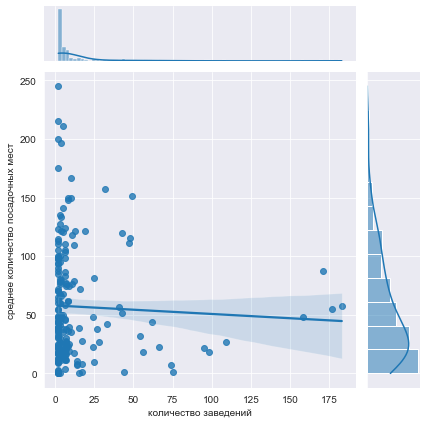

In [26]:
#построим джоинтплот распределения сетей
plt.figure(figsize=(20,8)) 
sns.set_style('darkgrid')
sns.jointplot(x='количество заведений', y='среднее количество посадочных мест', data=lm_df_chain, kind='reg')
plt.show()

In [27]:
#Определим границы для категорий "много" и "мало" заведений в сети по 33-му и 66-му процентилю
print(np.percentile(lm_df_chain['количество заведений'], [33, 66]))


In [28]:
#Определим границы для категорий "много" и "мало" мест в заведениях сети по 33-му и 66-му процентилю
print(np.percentile(lm_df_chain['среднее количество посадочных мест'], [33, 66]))


In [29]:
#Разбиваем на группы по числу заведений
lm_df_chain['группа по числу заведений'] = pd.cut(lm_df_chain['количество заведений'], 
        bins=[0,2,7,np.inf], 
        labels=['мало заведений','средне заведений', 'много заведений'], 
        include_lowest=False)


In [30]:
#Разбиваем на группы по среднему числу посадочных мест
lm_df_chain['группа по числу мест'] = pd.cut(lm_df_chain['среднее количество посадочных мест'], 
        bins=[0,25,66,np.inf], 
        labels=['мало мест','средне мест', 'много мест'], 
        include_lowest=False)


In [31]:
lm_counts = lm_df_chain[['группа по числу заведений','группа по числу мест']].value_counts().reset_index()
lm_counts['группа по числу заведений'] = lm_counts['группа по числу заведений'].astype(str)
lm_counts['группа по числу мест'] = lm_counts['группа по числу мест'].astype(str)


In [32]:
lm_counts['индекс'] = lm_counts['группа по числу заведений'] + ', ' + lm_counts['группа по числу мест']
lm_counts = lm_counts.rename(columns={0:'сумма'})
lm_counts['доля от общего числа заведений'] = lm_counts['сумма'] / sum(lm_counts['сумма'])

lm_counts

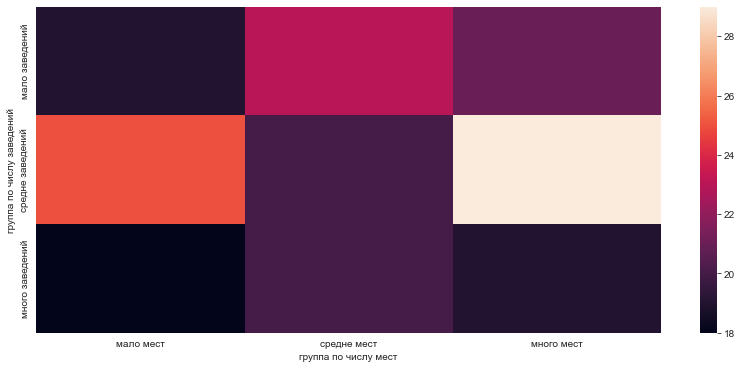

In [33]:
#строим хитмап по группам

plt.figure(
    figsize=(14, 6)) 
for_heatmap = pd.pivot_table(data=lm_df_chain, values='название сети',
                             index='группа по числу заведений',
                             columns='группа по числу мест',
                             aggfunc = 'count')
sns.heatmap(for_heatmap)
plt.show()


Среди сетей наиболее популярен формат со средним размером сети и большим числом мест. На них пиходится 15% сетей. На сети с большим числом заведений и малым числом мест - 9% всех сетей, представленных в Москве. На сети с малым количеством заведений, но большим количеством посадочных мест - 10%.

**Для сетевых заведений в сравнении с несетевыми из сегмента предприятий быстрого обслуживания характерно относительно большое число посадочных мест**. Если медианное значение для несетевых значений данного формата равно нулю, то у сетевых заведенией 25 посадочных мест. При этом, в предприятиях быстрого обслуживания у сетевиков максимальная доля (42%). Также среди форматов с существенной долей рынка по числу зваедений по медианным показателями числа посадочных мест "сетевики" значительно опережают несетевиков в формате "кафе" (40 против 30 посадовчных мест) и в формате "ресторан" (89 против 75 мест). **Таким образом, для сетевых заведений в форматах предпиятий быстрого обслуживания, магазинов с отделами кулинарии, ресторанов и кафе характерно наличие значительно большего количество посадочных мест, чем в несетевых заведениях**.

## Вместимость заведений по форматам <a class ="anchor" id="chapter5"></a>

In [34]:
#раситываем средние показатели вместимости по форматам
group_type = pd.pivot_table(df, values='number', index = 'object_type', aggfunc= ['mean','median']).reset_index()
group_type.columns = ['вид объекта','среднее число посадочных мест','медианное число посадочных мест']
group_type = group_type.sort_values('среднее число посадочных мест',ascending = False)
group_type

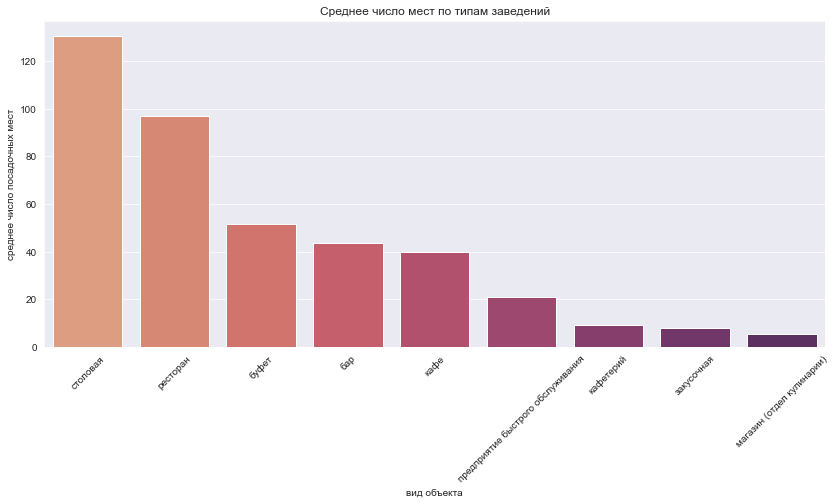

In [35]:
plt.figure(
    figsize=(14, 6)) 
plt.xticks(rotation = 45)
plt.title ('Среднее число мест по типам заведений')
ax = sns.barplot(x='вид объекта', y='среднее число посадочных мест', data=group_type, palette="flare")
plt.show()

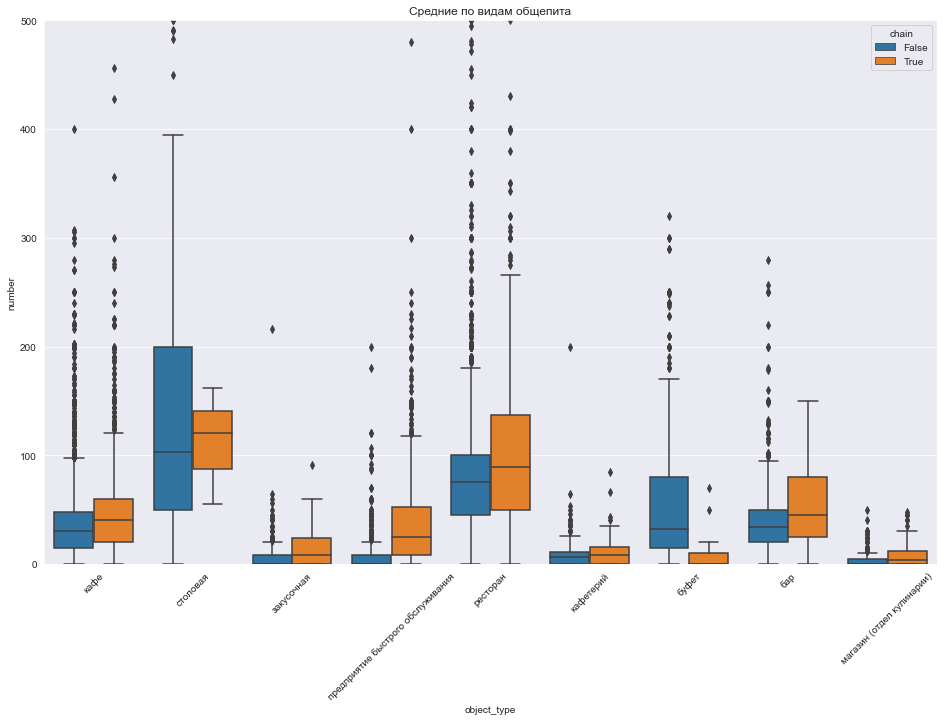

In [36]:
#строим график с набором боксплот для сетевых и несетевых заведений разных форматов, зададим ограничение для графика 500 местами
plt.figure(
    figsize=(16, 10)) 
plt.xticks(rotation = 45)
plt.title ('Средние по видам общепита')
ax=sns.boxplot(x='object_type', y='number', hue='chain', data=df) 
ax.set_ylim(0,500)
plt.show()

In [37]:
#Сделаем отдельный срез по кафе и определим парметры топ-10 кофейных сетей
lm_df_chain_cafe = (df.query('chain == True & object_type == "кафе"')
               .groupby('object_name')
               .agg({'id':'count','number':'mean'})
               .sort_values('id',ascending=False)
               .reset_index())
lm_df_chain_cafe.columns = ['название сети','количество заведений','среднее количество посадочных мест']
lm_df_chain_cafe_top_10 = lm_df_chain_cafe.head(10)
lm_df_chain_cafe_top_10

In [38]:
lm_df_chain_cafe_top_10['среднее количество посадочных мест'].median()

У форматов типа кафе, закусочная, предприятие быстрого обслуживания, бар и ресторан медианная "посадка" в сетевых заведениях заметно выше. **Будущему проекту можно порекомендовать стремиться к числу посадочных мест более характерному для сетевых заведений - то есть порядка 40. Медианное число мест по топ-10 московских сетей кофеен - 37. На это число и стоит ориентироваться**.

## Географический анализ рынка  <a class ="anchor" id="chapter6"></a>

In [39]:
#Выделим адрес в отдельный столбец 

words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))

df['street'] = df['address'].str.extract(str_pat, flags=re.I)

In [40]:
1 - (df['street'].isna().sum() / len(df['street']))

Метод сработал для 97% строк. Появление пропуска в соответствующем столбце связано с отсутствием указания улицы или иного топонимического атрибута в адресе.

In [41]:
#Выделим улицы с наибольшим числом заведений и дополним датасет координатами улиц

streets = df.groupby('street')['id'].count().sort_values(ascending=False).reset_index()
streets.columns = ['улица','число заведений']
top_streets = streets.head(10)

lat = [55.812368,55.649525,55.794285,55.746335,55.350581,55.682808,55.681671,55.735038,55.641249,55.614455 ]
long = [37.637937,37.532511,37.545635,37.539401,37.334783,37.537029,37.515353,37.509236,37.683203,37.605023]

top_streets['lat'] = pd.Series(lat)
top_streets['long'] = pd.Series(long)
top_streets


In [42]:
#Визуализируем расположение десяти самых популяных у общепита улиц
lat = top_streets['lat']
long = top_streets['long']
elevation = top_streets['улица']

moscow = folium.Map(location = [55.65, 37.56], zoom_start = 9.5, tiles = 'Stamen Toner')
latitudes = lat
longitudes = long

for i in range(0,len(top_streets)):
   folium.Marker(
      location=[top_streets.iloc[i]['lat'], top_streets.iloc[i]['long']],
      popup=top_streets.iloc[i]['улица'],
   ).add_to(moscow)
moscow


In [43]:
#зарузим датасет с районами Москвы
from io import BytesIO
import requests
spreadsheet_id = '1qbyzgiomhWjDX2mespdAXF6ap929wYzLjHSep0oC9rs'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id) 
r = requests.get(file_name)
moscow = pd.read_csv(BytesIO(r.content))
moscow

    

In [44]:
moscow ['streetname'] = moscow['streetname'].str.lower()

In [45]:
#Соединяем улицы с районами

merged_streets = pd.merge(top_streets, moscow, left_on="улица",right_on="streetname")
grouped_street = merged_streets.groupby('улица')['area'].apply(list).reset_index()
merged_streets = pd.merge(merged_streets, grouped_street, left_on="улица",right_on="улица")


In [46]:
merged_streets.columns = ['улица','число заведений','lat','long','streetname','areaid','okrug','area','перечень районов']
merged_streets = merged_streets.drop_duplicates(subset='улица')[['улица','число заведений','перечень районов']].reset_index(drop=True)

In [47]:
merged_streets

In [48]:
#Определим районы, через которые проходят топ-10 улиц.
from collections import Counter
test = merged_streets['перечень районов'].to_list()
temp_list = sum(test, [])
tl=Counter(temp_list)
count_areas = pd.Series(tl)
count_areas = count_areas.reset_index().sort_values(0, ascending=False).reset_index(drop=True)
count_areas.columns = ['Район','Число упоминаний в топ-10 улиц с числом ресторанов']
count_areas



In [49]:
#Районы, в которых присутсвуют две улицы, входящие в топ-10
count_areas['Район'].head(11).to_list()

Топ-10 улиц проходят через 37 районов. Через некоторые районы проходят две "топовые" улицы. К таким районам относятся Чертаново, Теплый стан, Гагаринский район, Ломоносовский район, Обручевский район и другие.

In [50]:
#Определим улицы Москвы с одним заведением их число
one_bar_street = df.groupby('street')['id'].count().sort_values().reset_index().query('id == 1')
one_bar_street['street'].nunique()

In [51]:
#Присоединим к их перечню районы
merged_one_bar_street =  pd.merge(one_bar_street, moscow, left_on="street",right_on="streetname")
grouped_one_bar_street = merged_one_bar_street.groupby('street')['area'].apply(list).reset_index()
grouped_one_bar_street.columns = ['улица','перечень районов']
grouped_one_bar_street.head(5)




In [52]:
#Расчитаем районы с максимальным числом улиц с одним заведением
test = grouped_one_bar_street['перечень районов'].to_list()
temp_list = sum(test, [])
tl=Counter(temp_list)
count_areas = pd.Series(tl)
count_areas = count_areas.reset_index().sort_values(0, ascending=False).reset_index(drop=True)
count_areas.columns = ['район','число улиц с одним заведением в районе']
count_areas

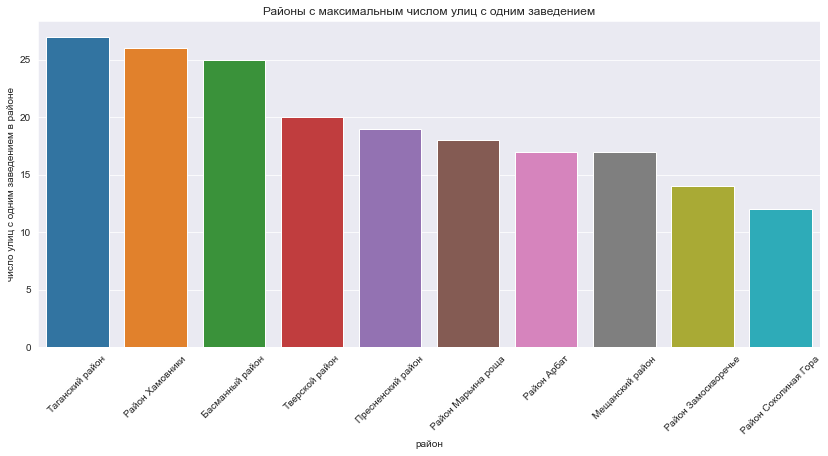

In [53]:
#Визуализируем распределение улиц с одним заведением по районам

top_one_bar_street_areas = count_areas.head(10)
plt.figure(
    figsize=(14, 6)) 
plt.xticks(rotation = 45)
plt.title ('Районы с максимальным числом улиц с одним заведением')
ax = sns.barplot(x='район', y='число улиц с одним заведением в районе', data=top_one_bar_street_areas)


В Москве есть более **полутысячи улиц** с одним заведением общественного питания на каждой. Больше всего их сосредоточено в Таганском районе, Хамовниках, а также в Басманном, Тверскм и Пресненских районах. Это центр Москвы. С учетом эксклюзивности планируемого проекта, возможно, стоит сосредоточится на поиске помещения на одной улиц с минимальным количеством заведений в этих районах.  

## Общие выводы  <a class ="anchor" id="chapter7"></a>

1. **Датасет содержит в себе данные довольно низкого качества**. В частности заведения одной и той же сети поименованы на разных языках, а также атрибутируются дополнительными техническими пометками. **В процессе предобработки данных из названий были вычищены технические пометки, а "сетевые" заведения с одним объектом исключались из анализа так как преимущественно представляют собой строки с некорректно введенными названиями сетей.   

2. **Подавляющее число заведений в Москве не являются сетевыми. На них приходится почти 81% рынка по числу заведений и почти 83% по "посадке"**. Самый популярный формат заведения в среднем по рынку это кафе. На него приходится 40% московских заведений и 26% "посадки". Максимальная доля "посадки" у столовых (37%) при доле в числе заведений в 17%. На рестораны приходится 15% заведений и 24% мест. Предприятия быстрого обслуживания занимают 12% рынка по числу заведений и всего 4% по посадке. 

***Формат кафе является оптимальным в связи с высокой популярностью данного формата в Москве и сравнительно небольшим объемом инвестиций (медианная "посадка" в два раза ниже, чем в ресторане - 40 и 89 мест соответственно) и большей маржинальностью, чем в формате столовых***.


4. **На рынке общественного питания Москвы самая большая доля сетевых объектов у предприятий быстрого обслуживания - 42%**. Также сравнительно велика доля сетевых магазинов с кулинарными отделами (29%). Почти четверть объектов являются сетевыми в форматах "ресторан" и "кафе" (24 и 23% соответственно). **Запуск несетевого кафе не несет в себе рисков входа на рынок с доминированием сетей**.


5. **Среди сетей наиболее популярен формат со средним размером сети и большим числом мест. На них пиходится 15% сетей**. На сети с большим числом заведений и малым числом мест - 9% всех сетей, представленных в Москве. **Подавляющее число сетей объединяют менее 20 точек**.


6. **Для сетевых заведений в сравнении с несетевыми из сегмента предприятий быстрого обслуживания характерно относительно большое число посадочных мест**. Если медианное значение для несетевых значений данного формата равно нулю, то у сетевых заведенией 25 посадочных мест. Среди форматов с существенной долей рынка по числу зваедений по медианным показателями числа посадочных мест "сетевики" значительно опережают несетевиков в формате "кафе" (40 против 30 посадочных мест) и в формате "ресторан" (89 против 75 мест). 


7. У форматов типа кафе, закусочная, предприятие быстрого обслуживания, бар и ресторан медианная "посадка" в сетевых заведениях заметно выше. Будущему проекту можно порекомендовать стремиться к числу посадочных мест более характерному для сетевых заведений - то есть порядка 40. **Медианное число мест по топ-10 московских сетей кофеен - 37. На это число и стоит ориентироваться при расчете финансовой модели проекта**.


8. **Топ-10 улиц проходят через 37 районов. Через некоторые районы проходят две "топовые" улицы. К таким районам относятся Чертаново, Теплый стан, Гагаринский район, Ломоносовский район, Обручевский район и другие**.


9. В Москве есть более полутысячи улиц с одним заведением общественного питания на каждой. **Больше всего их сосредоточено в Таганском районе, Хамовниках, Басманном, Тверским и Пресненских районах. Это центр Москвы. 

***С учетом эксклюзивности планируемого проекта, возможно, стоит сосредоточится на поиске помещения на одной улиц с минимальным количеством заведений в этих районах. При этом нужно провести отдельный анализ трафика в местах потенциального размещения заведения, а также дополнительно проанализировать финасовые показатели проектов сфере общепита в разных форматах в Москве***.


Ссылки на презентацию: https://disk.yandex.ru/i/63etJ0tFPl80qA

Дополнительно на гуглдок: https://docs.google.com/presentation/d/1mzafvdfSZEQCtgYKjS6C2CxiW8hlg6VFvPZdN6vJlJk/edit#slide=id.g14233377d77_0_93

